### Autoencoder-based portfolio choice: A model for stock returns.

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import cvxpy as cp

In [2]:
# Step 1: Load historical stock price data using yfinance
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]  # Add more tickers as needed
start_date = "2010-01-01"
end_date = "2022-01-01"

data = yf.download(tickers, start=start_date, end=end_date)
adj_close = data["Adj Close"]

# Step 2: Preprocess the data
scaler = StandardScaler()
returns = scaler.fit_transform(adj_close.pct_change().dropna())

[*********************100%%**********************]  5 of 5 completed


In [3]:
# Step 3: Build and train an autoencoder
input_dim = len(tickers)
encoding_dim = 3  # Number of encoding dimensions

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='linear')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(returns, returns, epochs=100, batch_size=32)

# Step 4: Use the trained autoencoder to reduce dimensionality
encoded_returns = autoencoder.predict(returns)

Epoch 1/100
91/91 [==============================] - 1s 2ms/step - loss: 1.1000
Epoch 2/100
91/91 [==============================] - 0s 2ms/step - loss: 0.9964
Epoch 3/100
91/91 [==============================] - 0s 2ms/step - loss: 0.9288
Epoch 4/100
91/91 [==============================] - 0s 1ms/step - loss: 0.8706
Epoch 5/100
91/91 [==============================] - 0s 1ms/step - loss: 0.8090
Epoch 6/100
91/91 [==============================] - 0s 1ms/step - loss: 0.7384
Epoch 7/100
91/91 [==============================] - 0s 1ms/step - loss: 0.6668
Epoch 8/100
91/91 [==============================] - 0s 1ms/step - loss: 0.6041
Epoch 9/100
91/91 [==============================] - 0s 2ms/step - loss: 0.5549
Epoch 10/100
91/91 [==============================] - 0s 1ms/step - loss: 0.5177
Epoch 11/100
91/91 [==============================] - 0s 2ms/step - loss: 0.4890
Epoch 12/100
91/91 [==============================] - 0s 2ms/step - loss: 0.4650
Epoch 13/100
91/91 [=================

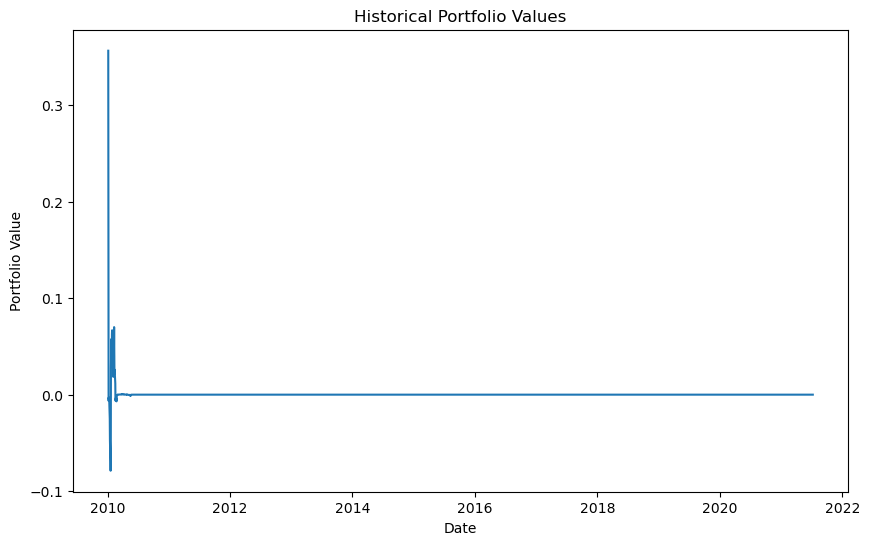

In [4]:
# Step 5: Calculate portfolio returns
weights = np.full(input_dim, 1.0 / input_dim)  # Equal-weighted portfolio
portfolio_returns = np.dot(returns, weights)

# Step 6: Create a time series plot of historical portfolio values
portfolio_values = np.cumprod(1 + portfolio_returns)
portfolio_dates = data.index[1:]  # Dates for portfolio values

# Ensure portfolio_values and portfolio_dates have the same length
if len(portfolio_values) > len(portfolio_dates):
    portfolio_values = portfolio_values[:len(portfolio_dates)]
elif len(portfolio_dates) > len(portfolio_values):
    portfolio_dates = portfolio_dates[:len(portfolio_values)]

plt.figure(figsize=(10, 6))
plt.plot(portfolio_dates, portfolio_values)
plt.title('Historical Portfolio Values')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

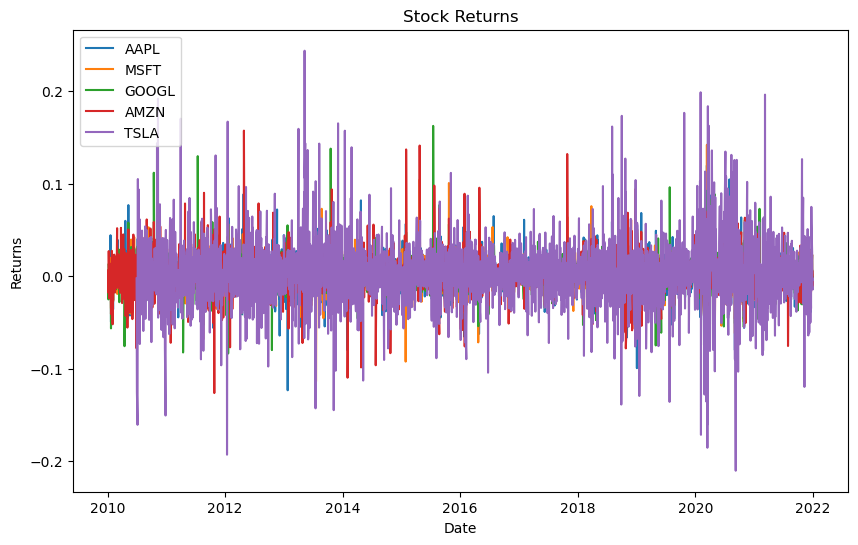

In [5]:
# Step 7: Create a time series plot of stock returns
plt.figure(figsize=(10, 6))
for ticker in tickers:
    ticker_returns = adj_close[ticker].pct_change().dropna()
    common_dates = data.index.intersection(ticker_returns.index)
    plt.plot(common_dates, ticker_returns[common_dates], label=ticker)

plt.title('Stock Returns')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.show()

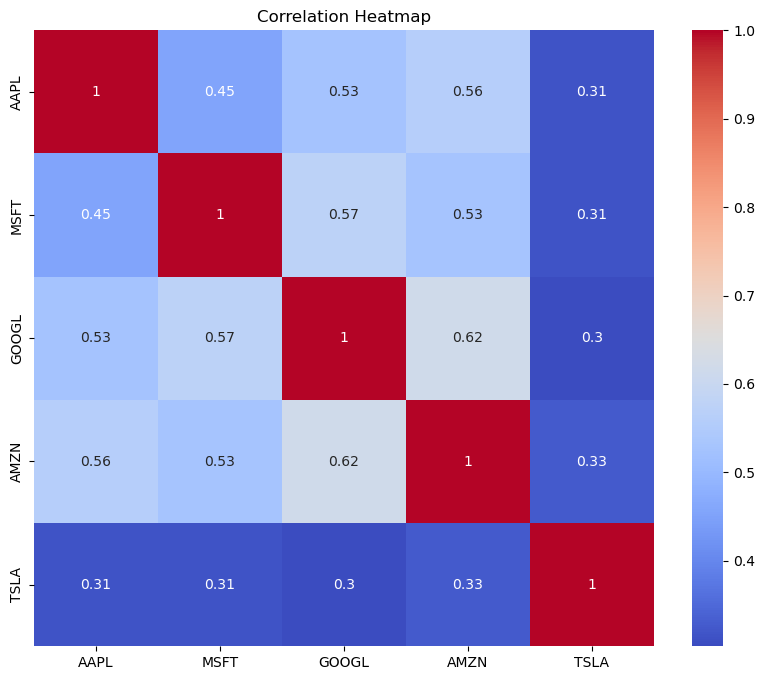

In [6]:
# Step 8: Create a heatmap of correlations
correlation_matrix = np.corrcoef(returns, rowvar=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=tickers, yticklabels=tickers)
plt.title('Correlation Heatmap')
plt.show()

Value-at-Risk (VaR) at 5.0% confidence: -119.87%


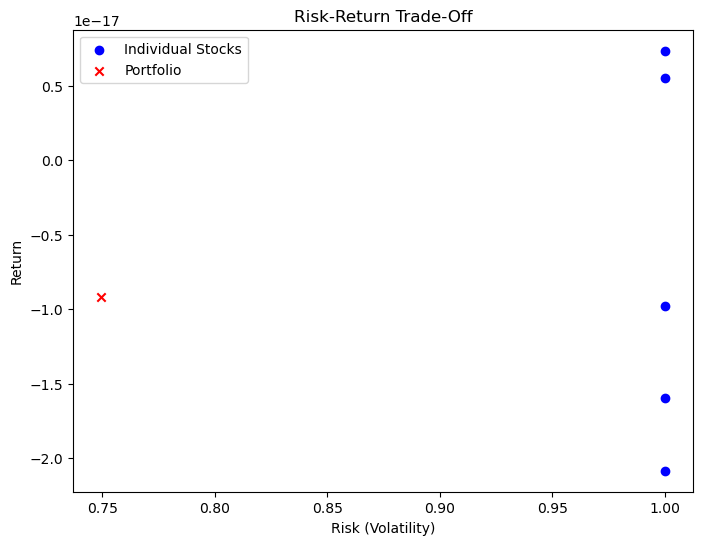

In [7]:
# Step 9: Calculate and visualize Value-at-Risk (VaR)
var_level = 0.05  # 95% confidence level
var = np.percentile(portfolio_returns, 100 * var_level)
print(f"Value-at-Risk (VaR) at {var_level*100}% confidence: {var:.2%}")

# Step 10: Risk-return trade-off visualization
plt.figure(figsize=(8, 6))
plt.scatter(np.std(returns, axis=0), np.mean(returns, axis=0), c='b', marker='o', label='Individual Stocks')
plt.scatter(np.std(portfolio_returns), np.mean(portfolio_returns), c='r', marker='x', label='Portfolio')
plt.title('Risk-Return Trade-Off')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Return')
plt.legend(loc='best')
plt.show()

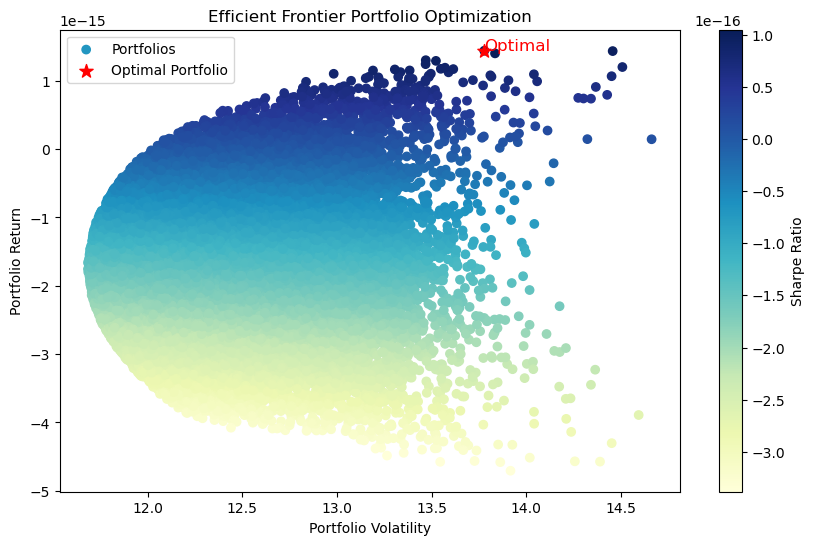

Optimal Portfolio Composition:
AAPL: 3.31%
MSFT: 14.28%
GOOGL: 24.26%
AMZN: 39.79%
TSLA: 18.37%


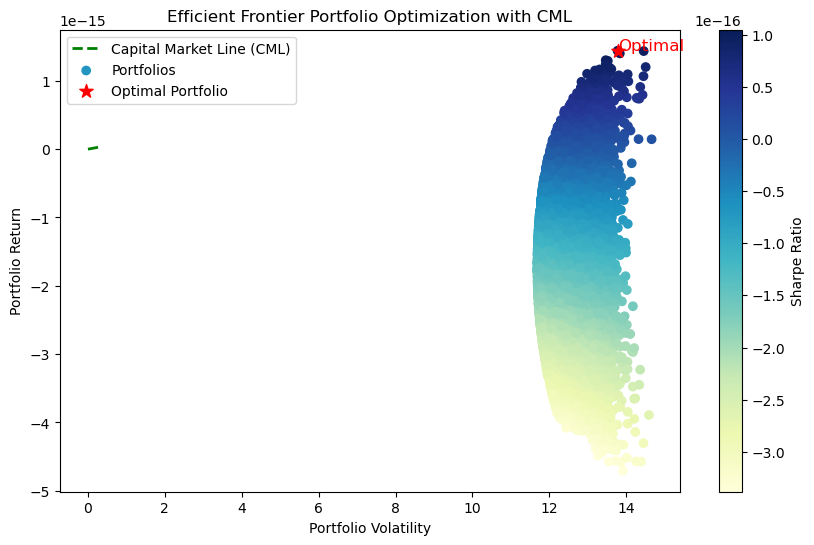

Portfolio Annualized Return: -0.00%
Portfolio Annualized Volatility (Risk): 1189.71%
Optimal Portfolio Return: 0.00%
Optimal Portfolio Volatility (Risk): 1377.80%
Optimal Weight of AAPL: 63.94%


In [8]:
# Step 11: Efficient Frontier Portfolio Optimization
mean_returns = np.mean(returns, axis=0)
cov_matrix = np.cov(returns, rowvar=False)

num_portfolios = 50000
results = np.zeros((4, num_portfolios))
risk_free_rate = 0.0  # You can adjust this rate

for i in range(num_portfolios):
    weights = np.random.random(input_dim)
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = (portfolio_return - risk_free_rate) / portfolio_stddev
    results[3, i] = weights[0]  # Store the weight of the first stock (AAPL)

# Find the portfolio with the maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
optimal_return = results[0, max_sharpe_idx]
optimal_volatility = results[1, max_sharpe_idx]
optimal_weight_AAPL = results[3, max_sharpe_idx]

# Plot the efficient frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o', label='Portfolios')
plt.title('Efficient Frontier Portfolio Optimization')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=100, label='Optimal Portfolio')
plt.annotate('Optimal', (optimal_volatility, optimal_return), color='red', fontsize=12)
plt.legend()
plt.show()

# Display the composition of the optimal portfolio
print("Optimal Portfolio Composition:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {weights[i]:.2%}")
    
# Calculate and plot the Capital Market Line (CML)
risk_free_return = risk_free_rate * 252
cml_x = np.linspace(0, 0.3, 100)  # Adjust the range as needed
cml_y = risk_free_return + ((optimal_return - risk_free_return) / optimal_volatility) * cml_x

plt.figure(figsize=(10, 6))
plt.plot(cml_x, cml_y, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='YlGnBu', marker='o', label='Portfolios')
plt.title('Efficient Frontier Portfolio Optimization with CML')
plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(optimal_volatility, optimal_return, c='red', marker='*', s=100, label='Optimal Portfolio')
plt.annotate('Optimal', (optimal_volatility, optimal_return), color='red', fontsize=12)
plt.legend()
plt.show()

# Example output
print(f"Portfolio Annualized Return: {np.mean(portfolio_returns) * 252:.2%}")
print(f"Portfolio Annualized Volatility (Risk): {np.std(portfolio_returns) * np.sqrt(252):.2%}")
print(f"Optimal Portfolio Return: {optimal_return:.2%}")
print(f"Optimal Portfolio Volatility (Risk): {optimal_volatility:.2%}")
print(f"Optimal Weight of AAPL: {optimal_weight_AAPL:.2%}")